<a href="https://colab.research.google.com/github/joyboy129/federated/blob/main/First_Scenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@test {"skip": true}

!pip install --quiet --upgrade tensorflow-federated
import nest_asyncio
nest_asyncio.apply()

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import MinMaxScaler


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train_data.csv", sep=',', encoding='latin-1')
df1=pd.read_csv("/content/drive/MyDrive/balanced_test_data.csv", sep=',', encoding='latin-1')
df.head()

,A,delta,TM,DELTA_TM,ElectronÃ©gativitÃ©,Delta_Electro-,SID,VEC,Delta VEC,K,Delta K,Etat d'entropie
0,1.966667,0.023970,2824.483333,0.191931,1.906667,0.204179,9.133863,6.333333,0.471405,253.333333,87.305339,1
1,1.942000,0.138397,2292.310000,0.247827,1.604700,0.195077,13.246961,4.380000,0.485386,116.300000,64.275267,0
2,1.825000,0.059711,1928.462500,0.484838,1.722500,0.146181,11.525651,6.250000,1.920286,184.000000,112.418860,1
3,1.759677,0.080665,1822.512903,0.117341,1.780161,0.139486,13.969797,7.596774,2.253740,160.516129,28.987062,1
4,1.800000,0.068041,1887.650000,0.145885,1.687500,0.134606,11.525651,7.000000,1.870829,155.000000,21.794495,1


In [ ]:
df.shape

(3274, 12)

In [ ]:
# df.dtypes
# # df=df.iloc[:50000]
# # Run for small data
df.rename(columns={"ElectronÃ©gativitÃ©": "Electronégativité"}, inplace=True)
df1.rename(columns={"ElectronÃ©gativitÃ©": "Electronégativité"}, inplace=True)

# df.columns
# df.drop(['Alloy', 'Longue Phase', 'Ag', 'Al', 'Cd', 'Ga', 'Mg', 'Pt', 'Sb',
#        'Sn', 'Ti', 'Zn', 'Zr', 'B', 'Ca', 'Ce', 'Co', 'Cr', 'Cu', 'Er', 'Fe',
#        'In', 'La', 'Li', 'Mn', 'Mo', 'Nd', 'Ni', 'Re', 'Ru', 'Sm', 'V', 'Yb',
#        'Au', 'Be', 'Bi', 'Pb', 'Nb', 'Si', 'Dy', 'Ge', 'Hf', 'W', 'Pd', 'Sr',
#        'Na', 'Y', 'Ta', 'Gd', 'Rh', 'P', 'C', 'Ho', 'Pr', 'N', 'Tb', 'Sc',
#        'Tm', 'Lu', 'Ir', 'Os', 'As', 'Tc'], axis=1, inplace=True)


In [ ]:
df.shape

(3274, 12)

In [ ]:

# df["Etat d'entropie"] = df["Etat d'entropie"].map({'H': 1, 'L': 0})
# df["Etat d'entropie"].value_counts()

In [ ]:
column_names=list(df.columns)
print(column_names)

['A', 'delta', 'TM', 'DELTA_TM', 'Electronégativité', 'Delta_Electro-', 'SID', 'VEC', 'Delta VEC', 'K', 'Delta K', "Etat d'entropie"]


In [ ]:
# import random
# client1 = int((client1/100) *df.shape[0])
# client2 = int((client2/100) *df.shape[0])
# client3 = int((client3/100) *df.shape[0])
# client4 = df.shape[0] - client1 - client2 - client3
# my_list = [1] * client1 + [2] * client2 + [3] * client3 + [4] * client4
# random.shuffle(my_list)
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

client_distributions = {
    1: {'percentage': 0.35, 'distribution': [0.3, 0.7]},
    2: {'percentage': 0.30, 'distribution': [0.35, 0.65]},
    3: {'percentage': 0.15, 'distribution':[0.55, 0.45]},
    4: {'percentage': 0.2, 'distribution': [0.8, 0.2]},

}
def distribute_dataframe(df, client_distributions):
    np.random.seed(42)

    # Separate the dataframe into 0s and 1s
    df0 = df[df['Etat d\'entropie'] == 0]
    df1 = df[df['Etat d\'entropie'] == 1]

    # Perform undersampling
    # if len(df0) > len(df1):
    #     df0 = df0.sample(len(df1))
    # else:
    #     df1 = df1.sample(len(df0))

    # Combine back to a single dataframe

    distributed_df = pd.DataFrame()

    for client_id, client_info in client_distributions.items():
        client_percentage = client_info['percentage']
        class_distribution = client_info['distribution']

        # Calculate the exact number of rows for this client
        n_rows = int(client_percentage * len(df))

        # Calculate desired number of samples for each class
        n0 = int(class_distribution[0] * n_rows)
        n1 = n_rows - n0

        # Check if there are enough samples for each class
        if n0 > len(df0):
            n0 = len(df0)
        if n1 > len(df1):
            n1 = len(df1)

        # Sample the rows for this client
        tmp_df0 = df0.sample(n=n0, random_state=42)
        tmp_df1 = df1.sample(n=n1, random_state=42)

        # Drop these rows from the original dataframes
        df0 = df0.drop(tmp_df0.index)
        df1 = df1.drop(tmp_df1.index)

        # Add the client id and combine the samples
        tmp_df = pd.concat([tmp_df0, tmp_df1])
        tmp_df['id'] = client_id

        distributed_df = pd.concat([distributed_df, tmp_df])


    return distributed_df

df =distribute_dataframe(df, client_distributions)
combined_df = pd.concat([df, df1])

# Create a copy of the data excluding the specified column

# Prepare the 'id' column
# ids = np.random.choice([1,2,3,4], size=len(df), p=list(id_percentages.values()))
# df['id'] = ids

# # Prepare the "Etat d'entropie" column
# for id_val, percentages in entropy_percentages.items():
#     size = len(df[df['id'] == id_val])
#     entropy_values = np.random.choice([0,1], size=size, p=list(percentages.values()))
#     df.loc[df['id'] == id_val, 'Etat d\'entropie'] = entropy_values
df.head()

,A,delta,TM,DELTA_TM,Electronégativité,Delta_Electro-,SID,VEC,Delta VEC,K,Delta K,Etat d'entropie,id
109,2.000000,0.061237,2621.400000,0.239459,1.737500,0.386159,11.525651,5.250000,0.829156,185.000000,75.000000,0,1
367,1.866667,0.088815,1875.676316,0.118119,1.642281,0.177280,14.834407,6.280702,1.935399,129.824561,55.139098,0,1
3173,1.833333,0.068030,2299.150000,0.200081,2.106667,0.167597,9.133863,8.000000,1.414214,263.333333,84.983659,0,1
2018,1.675000,0.077555,1394.212500,0.235613,1.837500,0.131791,11.525651,4.500000,3.354102,114.000000,39.344631,0,1
902,2.040000,0.049990,2469.550000,0.209455,1.638000,0.281595,13.380867,5.000000,0.894427,140.000000,80.746517,0,1


In [ ]:
df.shape

(3239, 13)

In [ ]:

def normalize_columns(df, columns_to_normalize):
    # Create a copy of the original dataframe
    normalized_df = df.copy()

    # Select the columns to normalize
    data_to_normalize = normalized_df[columns_to_normalize]

    # Create an instance of the scaler
    scaler = StandardScaler()

    # Fit the scaler to the selected columns
    scaler.fit(data_to_normalize)

    # Normalize the selected columns
    normalized_data = scaler.transform(data_to_normalize)

    # Update the normalized values in the dataframe
    normalized_df[columns_to_normalize] = normalized_data

    return normalized_df
df=normalize_columns(combined_df,['A', 'delta', 'TM', 'DELTA_TM', 'Electronégativité', 'Delta_Electro-', 'SID', 'VEC', 'Delta VEC', 'K', 'Delta K'])

df.head()

,A,delta,TM,DELTA_TM,Electronégativité,Delta_Electro-,SID,VEC,Delta VEC,K,Delta K,Etat d'entropie,id
109,1.064492,-0.080386,1.183516,0.211930,-0.475561,1.947841,0.236162,-0.197657,-1.040295,0.299245,0.511969,0,1
367,0.071225,0.689075,-0.388525,-1.170409,-0.912077,-0.216416,1.543045,0.440532,-0.150005,-0.811316,-0.110695,0,1
3173,-0.177092,0.109149,0.504189,-0.236679,1.216814,-0.316739,-0.708540,1.505085,-0.569448,1.875924,0.824970,0,1
2018,-1.356596,0.374898,-1.403486,0.168117,-0.017130,-0.687744,0.236162,-0.662041,0.991750,-1.129830,-0.605872,0,1
902,1.362472,-0.394196,0.863405,-0.129878,-0.931701,0.864428,0.968930,-0.352451,-0.987766,-0.606507,0.692130,0,1


In [ ]:
# Run for Bigdata only
NUM_CLIENTS = 5

# data = pd.read_csv("/content/drive/MyDrive/BigData.csv", sep=',', encoding='latin-1')

# data.rename(columns={"ElectronÃ©gativitÃ©": "Electronégativité"}, inplace=True)
# data.drop("Unnamed: 0", axis=1, inplace=True)
# data=normalize_columns(data,['A', 'delta', 'TM', 'DELTA_TM', 'Electronégativité', 'Delta_Electro-', 'SID', 'VEC', 'Delta VEC', 'K', 'Delta K'])
# data["id"]=NUM_CLIENTS
# minority_count = data["Etat d'entropie"].sum()
# majority_count = data.shape[0] - minority_count

# # Calculate the difference in counts between the classes
# count_diff = majority_count - minority_count

# # If the difference is positive, we need to add more samples of the minority class (1)
# # If the difference is negative, we need to remove samples of the majority class (0)

# if count_diff > 0:
#     # Get the indices of the rows with target value 1
#     minority_indices = data[data['Etat d\'entropie'] == 1].index
#     # Sample rows with replacement from the minority class to match the majority class count
#     additional_minority_indices = np.random.choice(minority_indices, count_diff, replace=True)
#     # Concatenate the additional samples with the original DataFrame
#     data = pd.concat([data, data.loc[additional_minority_indices]])
# elif count_diff < 0:
#     # Get the indices of the rows with target value 0
#     majority_indices = data[data["Etat d'entropie"] == 0].index
#     # Randomly select rows from the majority class to remove to match the minority class count
#     majority_indices_to_remove = np.random.choice(majority_indices, abs(count_diff), replace=False)
#     # Drop the selected rows from the majority class
#     data = data.drop(majority_indices_to_remove)
# df = pd.concat([df1, data], ignore_index=True)



In [ ]:
for id in range(1,NUM_CLIENTS+1):
  df[df["id"]==id].drop_duplicates(subset=['A', 'delta', 'TM', 'DELTA_TM', 'Electronégativité', 'Delta_Electro-', 'SID', 'VEC', 'Delta VEC', 'K', 'Delta K'])


# df=df.drop_duplicates(subset=['A', 'delta', 'TM', 'DELTA_TM', 'Electronégativité', 'Delta_Electro-', 'SID', 'VEC', 'Delta VEC', 'K', 'Delta K'])

In [ ]:
df.columns

Index(['A', 'delta', 'TM', 'DELTA_TM', 'Electronégativité', 'Delta_Electro-',
       'SID', 'VEC', 'Delta VEC', 'K', 'Delta K', 'Etat d'entropie', 'id'],
      dtype='object')

In [ ]:
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt


def pair_plot(df):
  etat_entropie_values = [0, 1]

# Plotting the density plots
  id_values = range(1,NUM_CLIENTS+1)

# Plotting the density plots
  num_rows = 11
  num_cols = NUM_CLIENTS
  num_plots = num_rows * num_cols

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 36))
  axes = axes.flatten()

  for i, col in enumerate(df.columns):
    if col != 'id' and col != 'Etat d\'entropie':
        for j, id_value in enumerate(id_values):
            ax = axes[(i * len(id_values)) + j]
            for etat_entropie in [0, 1]:
                filtered_data = df[df['Etat d\'entropie'] == etat_entropie]
                if not filtered_data.empty:
                    filtered_data[col].plot(kind='density', label=f'Etat Entropie = {etat_entropie}', ax=ax)
            filtered_data = df[(df['Etat d\'entropie'] == 0) | (df['Etat d\'entropie'] == 1)]
            if not filtered_data.empty:
                filtered_data[col].plot(kind='density', label='All Data', ax=ax, linestyle='--')
            ax.set_title(f'Density Plot - {col}, id = {id_value}')
            ax.legend()

  plt.tight_layout()
  plt.show()
# pair_plot(df)



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
import nest_asyncio
nest_asyncio.apply()
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
np.random.seed(0)
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [ ]:
df.dtypes

A                    float64
delta                float64
TM                   float64
DELTA_TM             float64
Electronégativité    float64
Delta_Electro-       float64
SID                  float64
VEC                  float64
Delta VEC            float64
K                    float64
Delta K              float64
Etat d'entropie        int64
id                     int64
dtype: object

In [ ]:
# split client id into train and test clients
client_id_colname = 'id' # the column that represents client ID
client_ids = df[client_id_colname].unique()
train_client_ids = range(1,NUM_CLIENTS)
test_client_ids = [NUM_CLIENTS]
print(client_ids)

[1 2 3 4 5]


In [ ]:
def create_tf_dataset_for_client_fn(client_id):
  # a function which takes a client_id and returns a
  # tf.data.Dataset for that client
    client_data = df[df[client_id_colname] == client_id]
    client_data = client_data.drop(columns=["id"])
    dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
    dataset = dataset.shuffle(SHUFFLE_BUFFER).batch(1).repeat(NUM_EPOCHS)
    return dataset

In [ ]:
NUM_EPOCHS =10
BATCH_SIZE = 512
SHUFFLE_BUFFER = 2000
PREFETCH_BUFFER = 1000



train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=train_client_ids,
        serializable_dataset_fn=create_tf_dataset_for_client_fn
    )

#
test_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=test_client_ids,
        serializable_dataset_fn=create_tf_dataset_for_client_fn
    )

In [ ]:
train_data.element_type_structure

{'A': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'delta': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'TM': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'DELTA_TM': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'Electronégativité': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'Delta_Electro-': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'SID': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'VEC': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'Delta VEC': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'K': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'Delta K': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 "Etat d'entropie": TensorSpec(shape=(None,), dtype=tf.int32, name=None)}

In [ ]:
example_dataset = train_data.create_tf_dataset_for_client(
    train_data.client_ids[0])

example_element = next(iter(example_dataset))


In [ ]:

def preprocess(dataset):

        def batch_format_fn(element):
            output = tf.concat([
                tf.expand_dims(element['Electronégativité'],1)
                ,tf.expand_dims(element['Delta_Electro-'],1)
                ,tf.expand_dims(element['SID'],1)
                ,tf.expand_dims(element['VEC'],1)
                ,tf.expand_dims(element['Delta VEC'],1)
                ,tf.expand_dims(element[ 'K'],1)
                ,tf.expand_dims(element['Delta K'],1)
                ,tf.expand_dims(element['A'],1)
                ,tf.expand_dims(element['delta'],1)
                ,tf.expand_dims(element['TM'],1)
                ,tf.expand_dims(element['DELTA_TM'],1)], axis=1)
            return collections.OrderedDict(x= tf.reshape(output, [1, 11] )
                                           ,
                                           y= tf.reshape(element["Etat d'entropie"], [1,1]) )

        return dataset.map(batch_format_fn)

In [ ]:

preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[-0.71623796, -0.701324  ,  0.2361621 ,  0.4215221 , -1.0402954 ,
                       0.6514819 ,  1.235407  ,  0.31954154, -0.7506224 ,  0.5468773 ,
                       0.9417596 ]], dtype=float32)),
             ('y', array([[1]], dtype=int32))])

In [ ]:
def make_federated_data(client_data, client_ids):
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [ ]:
sample_clients = train_data.client_ids[0:NUM_CLIENTS]
# sample_clients_test=test_data.client_ids[0:NUM_CLIENTS]
federated_train_data = make_federated_data(train_data, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 4
First dataset: <_MapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(1, 11), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(1, 1), dtype=tf.int32, name=None))])>


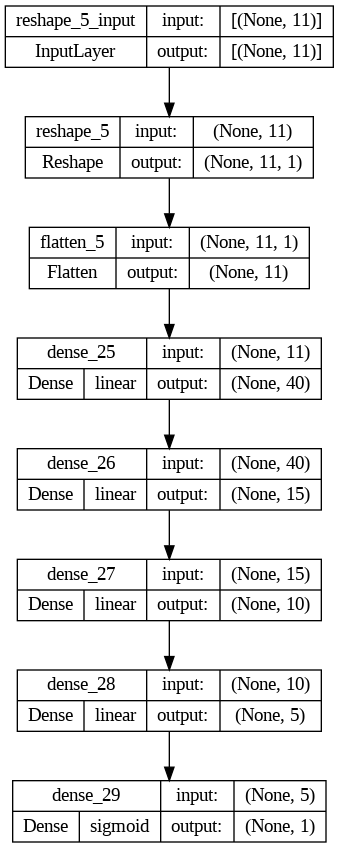

In [ ]:

def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Reshape(target_shape=(11, 1), input_shape=(11,)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(40, kernel_initializer='glorot_uniform'),
        tf.keras.layers.Dense(15, kernel_initializer='glorot_uniform'),
        tf.keras.layers.Dense(10, kernel_initializer='glorot_uniform'),
        tf.keras.layers.Dense(5, kernel_initializer='glorot_uniform'),
        tf.keras.layers.Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid')
    ])

# RNN
# def create_keras_model():
#     return tf.keras.models.Sequential([
#         tf.keras.layers.Reshape(target_shape=(11, 1), input_shape=(11,)),
#         tf.keras.layers.SimpleRNN(32),
#         tf.keras.layers.Dense(85, kernel_initializer='zeros'),
#         tf.keras.layers.Dense(60, kernel_initializer='zeros'),
#         tf.keras.layers.Dense(25, kernel_initializer='zeros'),
#         tf.keras.layers.Dense(10, kernel_initializer='zeros'),
#         tf.keras.layers.Softmax(),
#     ])
# def create_keras_model():
#     return tf.keras.models.Sequential([
#         tf.keras.layers.Reshape(target_shape=(11, 1), input_shape=(11,)),
#         tf.keras.layers.LSTM(32),
#         tf.keras.layers.Dense(85, kernel_initializer='zeros'),
#         tf.keras.layers.Dense(60, kernel_initializer='zeros'),
#         tf.keras.layers.Dense(25, kernel_initializer='zeros'),
#         tf.keras.layers.Dense(10, kernel_initializer='zeros'),
#         tf.keras.layers.Dense(32, kernel_initializer='lecun_normal',activation='selu'),
#     ])
# def create_keras_model():
#     return tf.keras.models.Sequential([
#         tf.keras.layers.Reshape(target_shape=(11, 1), input_shape=(11,)),
#         tf.keras.layers.GRU(32),
#         tf.keras.layers.Dense(30, kernel_initializer='zeros'),
#         tf.keras.layers.Dense(25, kernel_initializer='zeros'),
#         tf.keras.layers.Dense(1, kernel_initializer='zeros'),
#         tf.keras.layers.Softmax(),
#     ])

model=create_keras_model()
tf.keras.utils.plot_model(
model,
to_file="model_ann.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

In [ ]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
    keras_model=keras_model,
    input_spec=preprocessed_example_dataset.element_spec,
    loss=tf.keras.losses.Poisson(reduction="auto", name="poisson"),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.FalseNegatives()
    ]
)

In [ ]:
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam())



In [ ]:
str(iterative_process.initialize.type_signature)

'( -> <global_model_weights=<trainable=<float32[11,40],float32[40],float32[40,15],float32[15],float32[15,10],float32[10],float32[10,5],float32[5],float32[5,1],float32[1]>,non_trainable=<>>,distributor=<>,client_work=<>,aggregator=<value_sum_process=<>,weight_sum_process=<>>,finalizer=<int64,float32[11,40],float32[11,40],float32[40],float32[40],float32[40,15],float32[40,15],float32[15],float32[15],float32[15,10],float32[15,10],float32[10],float32[10],float32[10,5],float32[10,5],float32[5],float32[5],float32[5,1],float32[5,1],float32[1],float32[1]>>@SERVER)'

In [ ]:
state = iterative_process.initialize()

In [ ]:
df.dtypes

A                    float64
delta                float64
TM                   float64
DELTA_TM             float64
Electronégativité    float64
Delta_Electro-       float64
SID                  float64
VEC                  float64
Delta VEC            float64
K                    float64
Delta K              float64
Etat d'entropie        int64
id                     int64
dtype: object

In [ ]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.45662242), ('true_positives', 15110.0), ('true_negatives', 9579.0), ('false_positives', 5211.0), ('false_negatives', 2490.0), ('loss', 0.77360225), ('num_examples', 32390), ('num_batches', 32390)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


In [ ]:
NUM_ROUNDS = 20

acc = []
for round_num in range(2, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    print('round {:2d}, metrics={}'.format(round_num, metrics))
    acc.append( metrics['client_work']['train'])

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.45662242), ('true_positives', 15098.0), ('true_negatives', 9575.0), ('false_positives', 5215.0), ('false_negatives', 2502.0), ('loss', 0.77325207), ('num_examples', 32390), ('num_batches', 32390)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.45662242), ('true_positives', 15097.0), ('true_negatives', 9574.0), ('false_positives', 5216.0), ('false_negatives', 2503.0), ('loss', 0.7731609), ('num_examples', 32390), ('num_batches', 32390)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  4, metrics=OrderedDict([('distributor', ()), ('client_

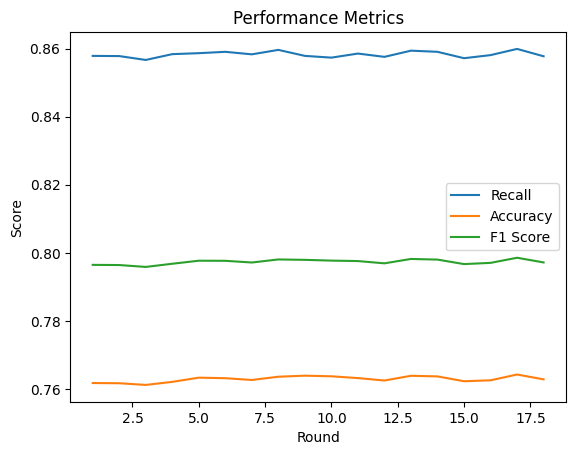

In [ ]:
from matplotlib.animation import FuncAnimation

tp_values = [int(i['true_positives']) for i in acc]  # List of true positives values for each round
tn_values = [int(i['true_negatives']) for i in acc]  # List of true negatives values for each round
fp_values = [int(i['false_positives']) for i in acc]  # List of false positives values for each round
fn_values = [int(i['false_negatives']) for i in acc]

accuracy_values = [(tp + tn) / (tp + tn + fp + fn) for tp, tn, fp, fn in zip(tp_values, tn_values, fp_values, fn_values)]
recall_values = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(tp_values, fn_values)]
f1_score_values = [tp/(tp+0.5*(fp+fn))  for tp, fp, fn in zip(tp_values, fp_values, fn_values)]

# Create x-axis values
rounds = np.arange(1, len(tp_values) + 1)

# Plot recall
plt.plot(rounds, recall_values, label='Recall')

# Plot accuracy
plt.plot(rounds, accuracy_values, label='Accuracy')

# Plot F1 score
plt.plot(rounds, f1_score_values, label='F1 Score')

# Set plot title and labels
plt.title('Performance Metrics')
plt.xlabel('Round')
plt.ylabel('Score')

# Add legend
plt.legend()

# Show the plot
plt.show()

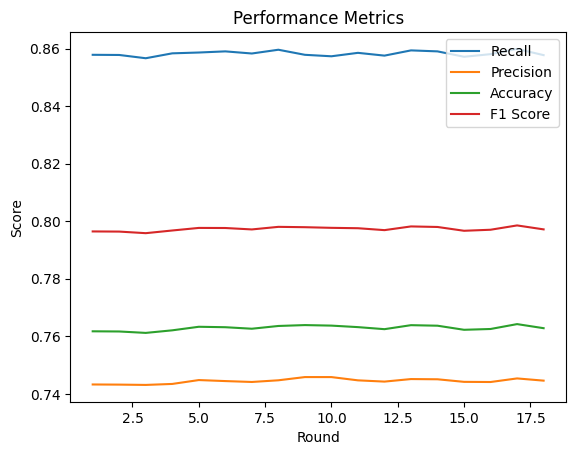

In [ ]:
precision_values= [tp  / (tp +fp ) for tp,  fp in zip(tp_values,  fp_values)]
# Plot recall
plt.plot(rounds, recall_values, label='Recall')
plt.plot(rounds, precision_values, label='Precision')

# Plot accuracy
plt.plot(rounds, accuracy_values, label='Accuracy')

# Plot F1 score
plt.plot(rounds, f1_score_values, label='F1 Score')

# Set plot title and labels
plt.title('Performance Metrics')
plt.xlabel('Round')
plt.ylabel('Score')

# Add legend
plt.legend()

# Show the plot
plt.show()

Evaluation process

In [ ]:

# Create a model function

# Use this model function to create a training process
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)

In [ ]:
print(evaluation_process.next.type_signature.formatted_representation())

(<
  state=<
    global_model_weights=<
      trainable=<
        float32[11,40],
        float32[40],
        float32[40,15],
        float32[15],
        float32[15,10],
        float32[10],
        float32[10,5],
        float32[5],
        float32[5,1],
        float32[1]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<
      <>,
      <
        sparse_categorical_accuracy=<
          float32,
          float32
        >,
        true_positives=<
          float32[1]
        >,
        true_negatives=<
          float32[1]
        >,
        false_positives=<
          float32[1]
        >,
        false_negatives=<
          float32[1]
        >,
        loss=<
          float32,
          float32
        >,
        num_examples=<
          int64
        >,
        num_batches=<
          int64
        >
      >
    >,
    aggregator=<
      value_sum_process=<>,
      weight_sum_process=<>
    >,
    finalizer=<>
  >@SERVER,
  client_data={<
    x=floa

In [ ]:
evaluation_state = evaluation_process.initialize()
model_weights = iterative_process.get_model_weights(state)
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
federated_test_data = make_federated_data(test_data, test_data.client_ids)

len(federated_test_data), federated_test_data[0]

(1,
 <_MapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(1, 11), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(1, 1), dtype=tf.int32, name=None))])>)

In [ ]:
evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

<ipython-input-271-a79d3e099da3>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-271-a79d3e099da3>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


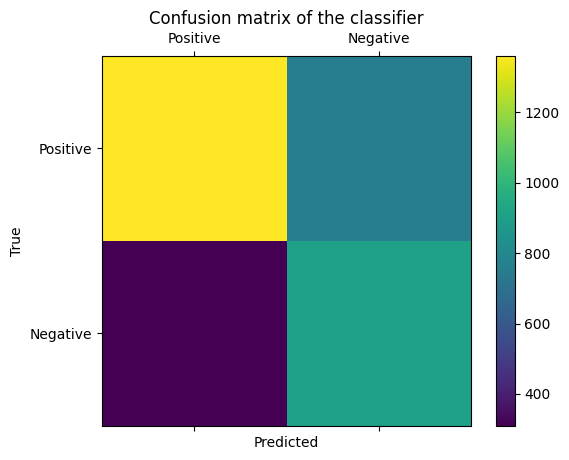

In [ ]:
tp = int(evaluation_output.metrics["client_work"]["eval"]['total_rounds_metrics']['true_positives'])
tn = int(evaluation_output.metrics["client_work"]["eval"]['total_rounds_metrics']['true_negatives'])
fp = int(evaluation_output.metrics["client_work"]["eval"]['total_rounds_metrics']['false_positives'])
fn = int(evaluation_output.metrics["client_work"]["eval"]['total_rounds_metrics']['false_negatives'])

cm = np.array([[tp, fp],
               [fn, tn]])

# labels
labels = ['Positive', 'Negative']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy=(tp+tn)/(tp+tn+fp+fn)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)
print("Accuracy:", accuracy)


table_html = """
<table>
  <tr>
    <th>Metric</th>
    <th>Value</th>
  </tr>
  <tr>
    <td>Precision</td>
    <td>{:.2f}</td>
  </tr>
  <tr>
    <td>Recall</td>
    <td>{:.2f}</td>
  </tr>
  <tr>
    <td>F1 Score</td>
    <td>{:.2f}</td>
  </tr>
  <tr>
    <td>Accuracy</td>
    <td>{:.2f}</td>
  </tr>
</table>
""".format(precision, recall, f1_score,accuracy)

# Display HTML table in Jupyter Notebook
from IPython.display import display, HTML
display(HTML(table_html))

Precision: 0.6415094339622641
Recall: 0.8143712574850299
F1 score: 0.7176781002638523
Accuracy: 0.6796407185628742


Metric,Value
Precision,0.64
Recall,0.81
F1 Score,0.72
Accuracy,0.68
